# 16. 흐린 사진을 선명하게

## 14. 프로젝트 : SRGAN 활용하기
앞에서 사용했던 SRGAN 구조를 이용해 프로젝트를 수행해보자.

### 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기
---
앞서 사용했던 `DIV2K` 데이터셋은 bicubic interpolation을 이용해 가로 및 세로 픽셀 수를 1/4로 줄인 저해상도 이미지와 원래 고해상도 이미지 사이에서 학습되었다. 이 데이터셋으로 학습된 SRGAN를 이용해 좋은 결과를 얻기 위해서는 위와 같은 과정이 동일하게 진행되는 것이 좋다.

아래와 같이 두 가지 다른 단계를 거쳐서 직접 고른 이미지에 대해 SRGAN을 적용해보자. (모델 학습을 진행하는 건 아니다.) 테스트할 이미지를 고를 때, `DIV2K` 의 학습 데이터셋과 비슷한 종류의 이미지가 좋다. 일반적으로 자연, 동물, 건물 등의 이미지가 학습에 사용되었으며, 이와 달리 애니메이션 등의 이미지는 고해상도로 잘 변환되지 않을 수 있다.

특정 데이터셋에서만 학습되었기 때문에, 일반적으로 좋지 않은 결과가 나올 가능성이 높다. 결과와 상관없이 아래 과정만 잘 수행해보자.

#### 프로젝트 1-1.

1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러온다.
2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄인다. `cv2.resize()`를 사용해본다.
3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성한다. 이전에 사용한 `apply_srgan` 함수를 사용하면 쉽다.
4. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘린다. 마찬가지로 `cv2.resize()`를 사용해본다.
5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화한다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시하자.
6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 보자.

(적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러온다.

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


width:  690
height: 455


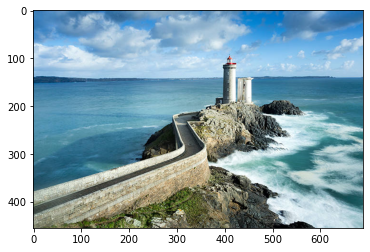

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import os
hr_image = os.getenv('HOME')+'/AIFFEL/Exploration/E16_SRGAN/image/hr_image.jpg'

hr_img_bgr = cv2.imread(hr_image)    #- OpenCV로 이미지를 읽기

print('width: ', hr_img_bgr.shape[1])
print('height:', hr_img_bgr.shape[0])

h, w, c = hr_img_bgr.shape

hr = cv2.cvtColor(hr_img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(hr)
plt.show()

불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄인다. `cv2.resize()`를 사용해본다.

(113, 172, 3)


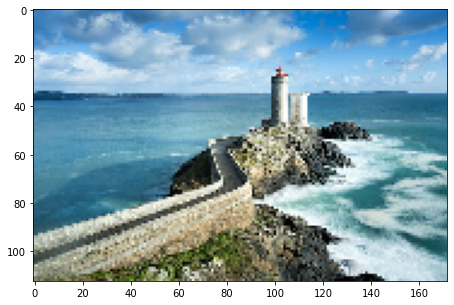

In [3]:
lr = cv2.resize(hr
    , dsize=(w//4, h//4)
    , interpolation = cv2.INTER_CUBIC) # bicubic 설정) # (가로 픽셀 수, 세로 픽셀 수)

print(lr.shape)

plt.figure(figsize=(10,5))
plt.imshow(lr)

줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성한다. 이전에 사용한 `apply_srgan` 함수를 사용하면 쉽다.

In [4]:
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/AIFFEL/Exploration/Practice/P16_SRGAN/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [5]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

In [6]:
srgan_hr = apply_srgan(lr)

Text(0.5, 1.0, 'HR')

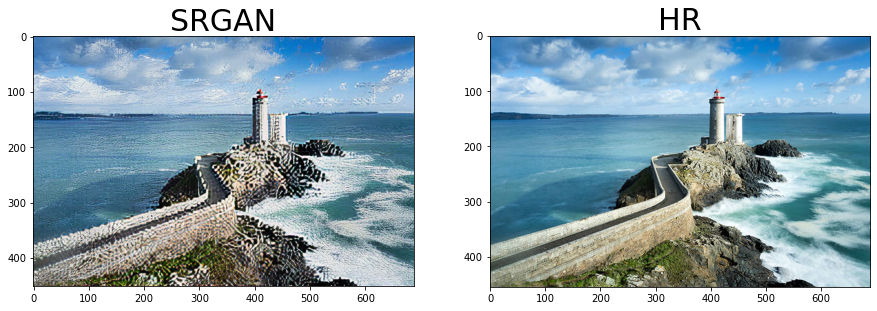

In [7]:

# 시각화 합니다.
plt.figure(figsize=(15,25))
plt.subplot(1,2,1); plt.imshow(srgan_hr); plt.title("SRGAN", fontsize=30)
plt.subplot(1,2,2); plt.imshow(hr); plt.title("HR", fontsize=30)

Text(0.5, 1.0, 'HR')

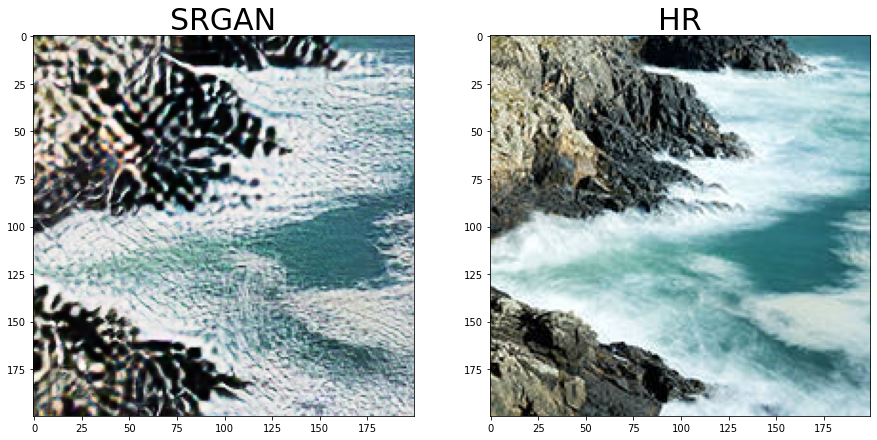

In [8]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# interpolation된 이미지와 고해상도 이미지의 동일한 부분을 각각 잘라냅니다.
left_top = (200, 400)
crop_srgan_hr = crop(srgan_hr, left_top)
crop_hr = crop(hr, left_top)

# 잘라낸 부분을 시각화 합니다.
plt.figure(figsize=(15,25))
plt.subplot(1,2,1); plt.imshow(crop_srgan_hr); plt.title("SRGAN", fontsize=30)
plt.subplot(1,2,2); plt.imshow(crop_hr); plt.title("HR", fontsize=30)

`lr` 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘린다. 마찬가지로 `cv2.resize()`를 사용해본다.

(455, 690, 3)


Text(0.5, 1.0, 'HR')

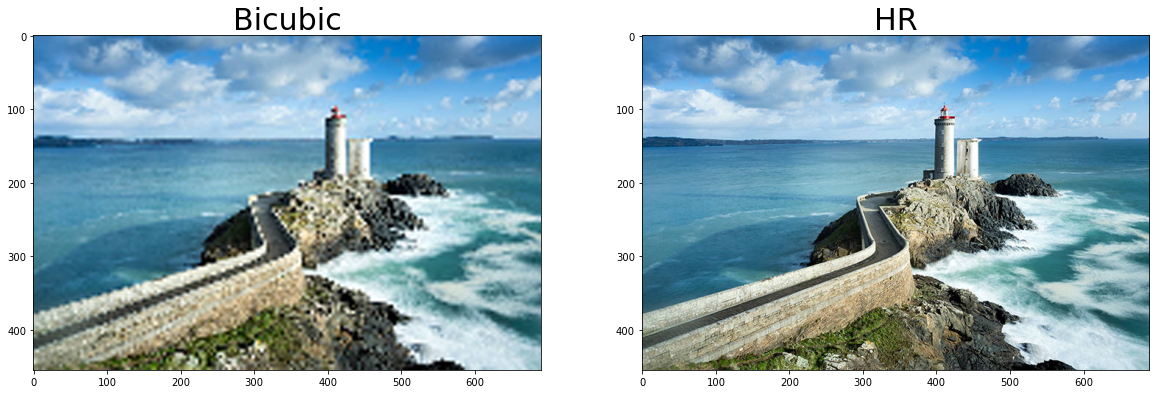

In [9]:
# 저해상도 이미지를 고해상도 이미지 크기로 bicubic interpolation 합니다.  
bicubic_hr = cv2.resize(
    lr,
    dsize = (w, h), # 고해상도 이미지 크기로 설정
    interpolation = cv2.INTER_CUBIC # bicubic 설정
)

print(bicubic_hr.shape)

# 저해상도 및 고해상도 이미지를 시각화합니다.
plt.figure(figsize=(20,10))
plt.subplot(1,2,1); plt.imshow(bicubic_hr); plt.title("Bicubic", fontsize=30)
plt.subplot(1,2,2); plt.imshow(hr); plt.title("HR", fontsize=30)

3개 이미지(Bicubic의 결과, SRGAN의 결과, 원래 고해상도 이미지)를 나란히 시각화한다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시하자.

Text(0.5, 1.0, 'HR')

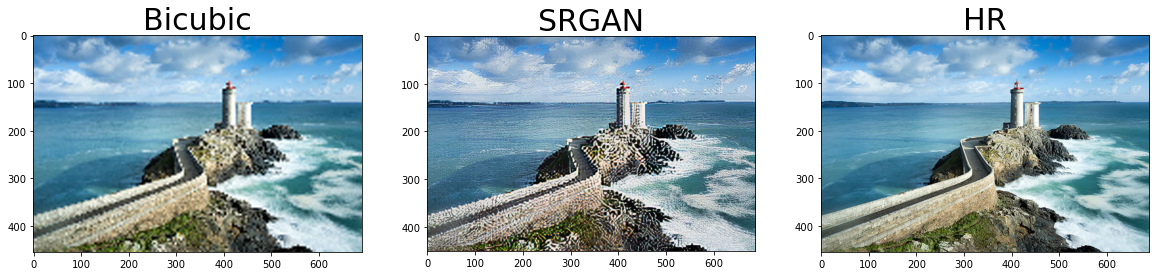

In [10]:
# 3개 이미지를 시각화 합니다.
plt.figure(figsize=(20,25))
plt.subplot(1,3,1); plt.imshow(bicubic_hr); plt.title("Bicubic", fontsize=30)
plt.subplot(1,3,2); plt.imshow(srgan_hr); plt.title("SRGAN", fontsize=30)
plt.subplot(1,3,3); plt.imshow(hr); plt.title("HR", fontsize=30)

In [11]:
print(bicubic_hr.shape)
print(srgan_hr.shape)
print(hr.shape)

(455, 690, 3)
(452, 688, 3)
(455, 690, 3)


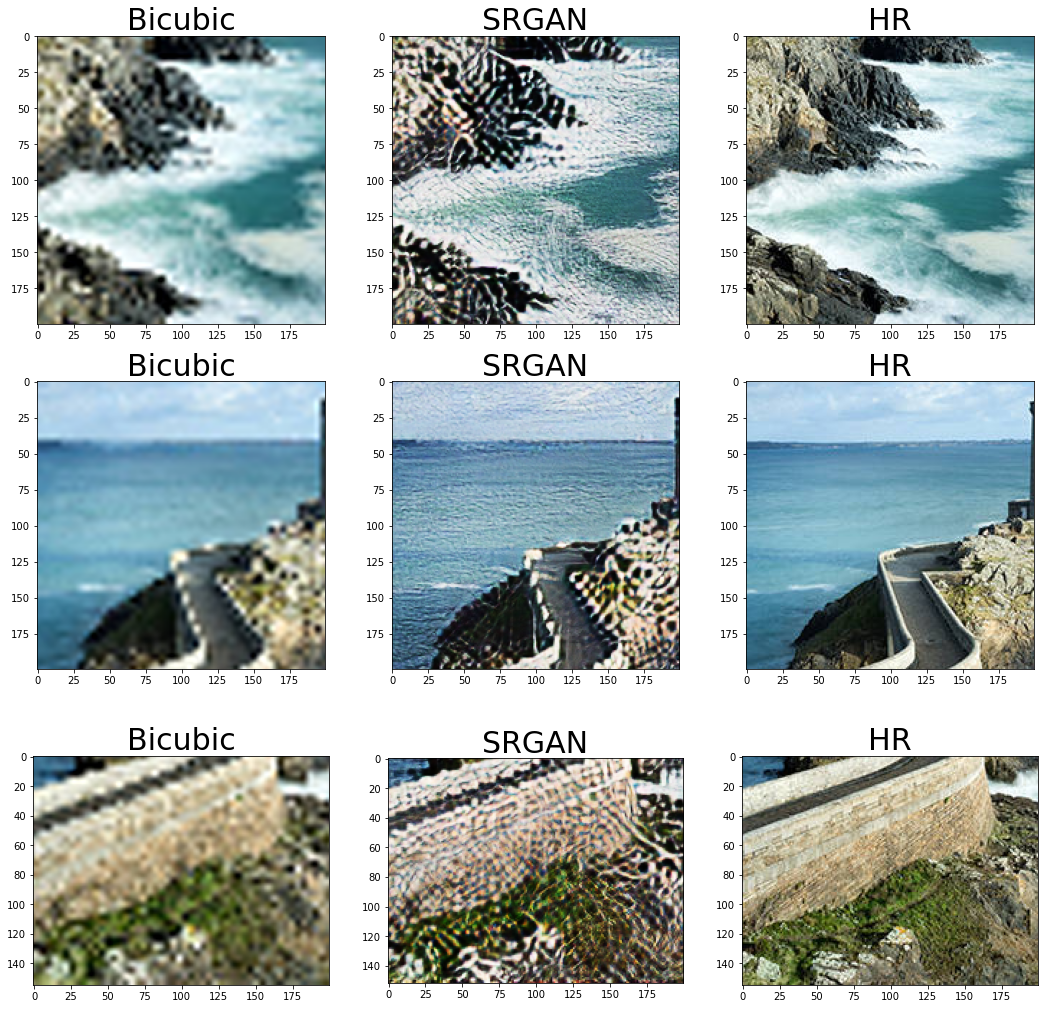

In [12]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(200,400), (100,200), (300,200)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 보자.

* 이미지가 밋밋한 부분(바다, 하늘) 부분은 개선이 잘 되었다.
* 그러나 바위, 길, 등대 같은 세세한 부분이나 굴곡이 있는 부분, 색이 다양한 부분은 잘 개선하지 못했다.

#### 프로젝트 1-2.

1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러온다.
2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성한다. 이전에 사용한 `apply_srgan` 함수를 사용하면 쉽다.
3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘린다. `cv2.resize()`를 사용해본다.
4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화한다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시하자.
5. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해보자.

(적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러온다.

width:  108
height: 108


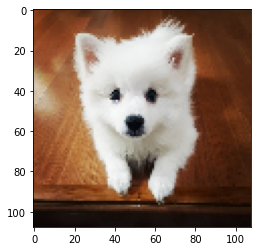

In [13]:
lr_image = os.getenv('HOME')+'/AIFFEL/Exploration/E16_SRGAN/image/lr_image.png'

lr_img_bgr = cv2.imread(lr_image)    #- OpenCV로 이미지를 읽기

print('width: ', lr_img_bgr.shape[1])
print('height:', lr_img_bgr.shape[0])

h, w, c = lr_img_bgr.shape

lr = cv2.cvtColor(lr_img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(lr)
plt.show()

불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성한다. 이전에 사용한 `apply_srgan` 함수를 사용하면 쉽다.

Text(0.5, 1.0, 'Lr')

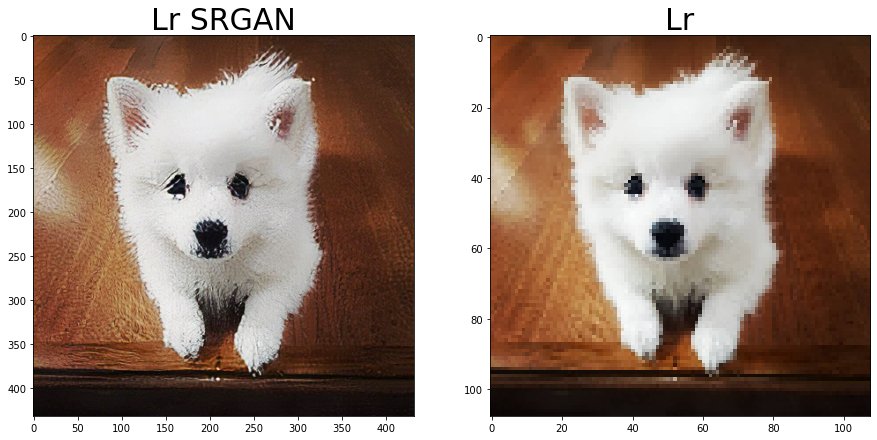

In [14]:
srgan_lr = apply_srgan(lr)

# 시각화 합니다.
plt.figure(figsize=(15,25))
plt.subplot(1,2,1); plt.imshow(srgan_lr); plt.title("Lr SRGAN", fontsize=30)
plt.subplot(1,2,2); plt.imshow(lr); plt.title("Lr", fontsize=30)

(적당히) 낮은 해상도를 가진 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘린다. `cv2.resize()`를 사용해본다.

In [15]:
# 저해상도 이미지를 고해상도 이미지 크기로 bicubic interpolation 합니다.  
bicubic_lr = cv2.resize(
    lr,
    dsize = (w * 4, h * 4), # 고해상도 이미지 크기로 설정
    interpolation = cv2.INTER_CUBIC # bicubic 설정
)


2개 이미지(Bicubic의 결과, SRGAN의 결과)를 나란히 시각화한다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시하자.

Text(0.5, 1.0, 'SRGAN')

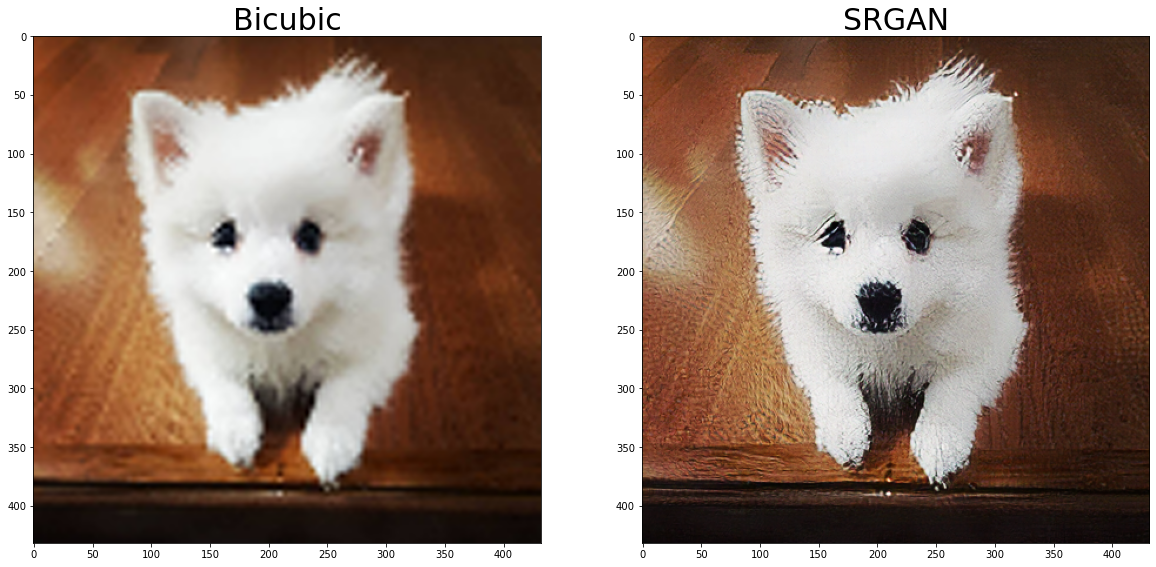

In [16]:
# 저해상도 및 고해상도 이미지를 시각화합니다.
plt.figure(figsize=(20,10))
plt.subplot(1,2,1); plt.imshow(bicubic_lr); plt.title("Bicubic", fontsize=30)
plt.subplot(1,2,2); plt.imshow(srgan_lr); plt.title("SRGAN", fontsize=30)

In [17]:
print(bicubic_lr.shape)
print(srgan_lr.shape)

(432, 432, 3)
(432, 432, 3)


선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해보자.

* 강아지 이미지의 털 하나하나를 선명하게 한듯한 이미지가 나왔다.(마치 유리 같은 모습??)
* SRGAN이 세세한 부분(털, 돌, 주름...)들을 자연스럽게 개선하지 못했다.

### 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기
---
이전 Super Resolution의 활용 사례에 대해 살펴봤을 때, 단일 이미지가 아닌 영상에 대해 Super Resolution을 적용한 사례가 있었다. 이번에는 이미 학습된 SRGAN을 이용해 저해상도 영상을 고해상도 영상으로 바꿔보는 프로젝트를 수행해보자.

실제로 동영상의 Super Resolution은 시간 순서에 따른 다수의 프레임 정보를 고려하는 것이 더 좋지만, 처음부터 학습시키기에 많은 시간이 소요된다. 여기서는 이전에 사용했던 SRGAN을 이용해 한 프레임씩 고해상도 이미지로 변환 시켜 모든 프레임에 대해 적용하고, 그 프레임들을 합쳐 동영상으로 만들어보자.

각 프레임들을 모아 gif 파일을 만드는데 아래 라이브러리의 설치가 필요하다.

```bash
$ pip install imageio
```

#### 1. gif 파일 불러오기
아래 주소에 몇 개의 gif 파일이 있다. 이 중 하나를 골라 다운 로드하여 아래 과정을 수행하자. (한 개 이상의 gif 파일에 대해 아래 과정을 수행해야 한다.)

__GIF files__ [https://drive.google.com/drive/folders/1OLsa4btdwNUiVJcOJgZe_C6-lwEoNr4e](https://drive.google.com/drive/folders/1OLsa4btdwNUiVJcOJgZe_C6-lwEoNr4e)

다운받은 gif 파일을 아래와 같은 과정을 통해 각 프레임(이미지)을 불러올 수 있다. `frames`이란 리스트 안에 각각의 프레임이 들어 있다.

```python
import cv2

# 다운받은 파일의 경로를 설정해 주세요.
gif = cv2.VideoCapture("저해상도.gif")

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))
```

#### 2. 프레임별 Super Resolution 진행하기
Bicubic interpolation과 SRGAN을 이용해 각각의 가로, 세로 픽셀 수를 4배로 늘려보자. Super Resolution이 완료된 각각의 결과를 `frames_sr`이라는 리스트에 넣어준다.

In [18]:
def bicubic(image):
    bicubic = cv2.resize(image, dsize=(w//4, h//4), interpolation = cv2.INTER_CUBIC) # bicubic 설정) # (가로 픽셀 수, 세로 픽셀 수)
    return bicubic

In [19]:
import cv2

# 다운받은 파일의 경로를 설정해 주세요.
gif = cv2.VideoCapture("./image/fire_lr.gif")

isTrue = True
frames = []
Bicubic =[]
SRGAN = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
        Bicubic.append(bicubic(frame))
        SRGAN.append(apply_srgan(frame))

In [20]:
print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))
print("Bicubic_frame 수 :", len(Bicubic))
print("frame 크기 :", (Bicubic[0].shape))
print("SRGAN_frame 수 :", len(SRGAN))
print("SRGAN_frame 크기 :", (SRGAN[0].shape))

frame 수 : 14
frame 크기 : (282, 300, 3)
Bicubic_frame 수 : 14
frame 크기 : (27, 27, 3)
SRGAN_frame 수 : 14
SRGAN_frame 크기 : (1128, 1200, 3)


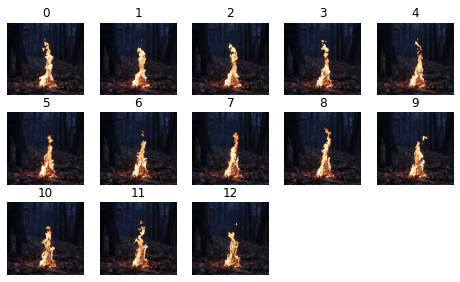

In [21]:
plt.figure(figsize=(8,8))
for i in range(13):
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.imshow(frames[i])
    plt.title(i)

#### 3. 프레임을 합쳐 gif 만들기
위에서 `frame_sr`을 만들었다면 아래 코드와 같이 gif 파일을 생성할 수 있다. Bicubic 및 SRGAN의 결과를 각각 저장하여 2개 파일을 만들자.

```python
import imageio

imageio.mimsave("고해상도.gif", frames_sr)
```

In [22]:
import imageio

imageio.mimsave(os.getenv('HOME')+'/AIFFEL/Exploration/E16_SRGAN/image/bicubic.gif', Bicubic)
imageio.mimsave(os.getenv('HOME')+'/AIFFEL/Exploration/E16_SRGAN/image/frames_sr.gif', SRGAN)

#### 4. Jupyter notebook에 gif 표시하기
아래와 같이 다운받은 저해상도 gif 파일과 고해상도 gif 파일을 각각 jupyter 내에 출력하여 최종 제출하면 된다. jupyter 내에 출력이 어려운 경우, GitHub에 저해상도, 고해상도 gif파일을 업로드 후 링크를 첨부해야한다. Super Resolution이 잘 적용되었는지 시각적으로 확인하기 위해 아래의 width 옵션을 적당히 크게 해야한다. 저해상도 및 고해상도 시각화의 width 값은 같도록 설정하자.

```python
from IPython.display import Image as show_gif

show_gif("저해상도.gif", width=800) # width 는 적당히 큰 값으로 설정해주세요
show_gif("고해상도.gif", width=800) # 위에서 설정한 width와 같은 값으로 설정해주세요
```

In [ ]:
from IPython.display import Image as show_gif

show_gif(os.getenv('HOME')+'/AIFFEL/Exploration/E16_SRGAN/image/bicubic.gif', width=800) # width 는 적당히 큰 값으로 설정해주세요

<img src="./image/bicubic.gif" width="30%" />

In [ ]:
show_gif(os.getenv('HOME')+'/AIFFEL/Exploration/E16_SRGAN/image/frames_sr.gif', width=800) # 위에서 설정한 width와 같은 값으로 설정해주세요

<img src="./image/frames_sr.gif" width="30%" />

### 회고
---
* 2019년 AI 페스티벌에서 고등학생들이 고전 게임의 해상도를 복원하는 프로젝트를 봤었는데 이런 식으로 진행했다는 것을 이해하게 되었다.
* 모델을 학습하지 않고 가져다 쓰는 것이 굉장히 편했다.(GAN은 모델 학습이 오래 걸리니까...)
* 솔직히 생각보다 SRGAN의 한계가 많아서 아쉬웠다.(조금 더 공부해보고 싶다는 생각ㅎ)

### 루브릭
---
* SRGAN을 이용해 고해상도의 이미지를 생성하였다.<br>
(_SRGAN을 통해 생성된 이미지를 제출하였다._)

    * __프로젝트 1-1, 1-2, 2에 전부 SRGAN을 적용하고 생성된 이미지를 제출했다.__

* 다양한 해상도의 이미지에 대해 시각화를 통해 원본, SRGAN생성본, interpolation생성본을 비교분석하였다.<br>
( _이미지의 특성과 super resolution 방법을 관련지어 생성 결과를 체계적으로 분석하였다._)
    
    * __왜 이런 결과가 나왔는지 분석했다.__

* 저해상도 gif 동영상을 고해상도 동영상으로 성공적으로 변환하였다.<br>
(_저해상도 원본 gif와 생성된 고해상도 gif의 해상도 차이가 시각적으로 확인 가능하다._)
    
    * __저해상도 gif와 고해상도 gif를 비교했다.__